<a href="https://www.kaggle.com/code/prasadposture121/cnn1024jnb?scriptVersionId=191291759" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CNN Trial Architectures

## Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
print("Libraries Imported")

Libraries Imported


## Loading the data

In [2]:
Halo = np.load('/kaggle/input/cnn1024sliced/Preprocessed_Train_Halo.npz')['array']
print(Halo.shape)
C2 = np.load('/kaggle/input/cnn1024sliced/Preprocessed_Train_C2.npz')['array']
print(C2.shape)

(12288, 1, 16, 16, 16)
(12288, 1, 16, 16, 16)


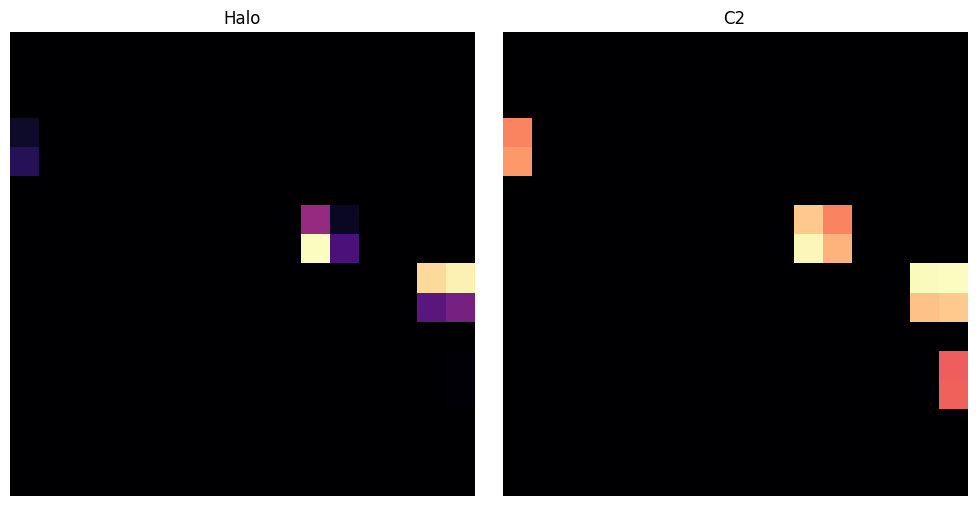

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(Halo[23][0][7], cmap='magma')
ax[0].set_title('Halo')
ax[0].axis('off')

ax[1].imshow(C2[23][0][7], cmap='magma')
ax[1].set_title('C2')
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Converting to PyTorch tensors
input_tensor = torch.tensor(Halo, dtype=torch.float32)
output_tensor = torch.tensor(C2, dtype=torch.float32)

# Creating a TensorDataset and DataLoader
dataset = TensorDataset(input_tensor, output_tensor)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Data Loaded")

Data Loaded


## UNet Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention3D(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention3D, self).__init__()
        self.query_conv = nn.Conv3d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv3d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv3d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, depth, height, width = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, depth * height * width).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, depth * height * width)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, depth * height * width)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, depth, height, width)
        out = self.gamma * out + x
        return out

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SelfAttention3D(512),
            nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        )
        
        # Decoder
        self.dec3 = nn.Sequential(
            nn.Conv3d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        )
        self.dec2 = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        )
        self.dec1 = nn.Sequential(
            nn.Conv3d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, out_channels, kernel_size=1)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc3)
        
        # Decoder with skip connections
        dec3 = self.dec3(torch.cat((bottleneck, enc3), dim=1))
        dec2 = self.dec2(torch.cat((dec3, enc2), dim=1))
        dec1 = self.dec1(torch.cat((dec2, enc1), dim=1))
        
        return dec1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3D(in_channels=1, out_channels=1).to(device)

## Training Process

In [6]:
# Splitting data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loading them into batches for more efficient RAM usage
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Defining the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters: so that our training process stops the moment there is no improvement in the validation loss
early_stopping_patience = 5 # these are number of times we will wait if our model improves (if its not improving)
min_val_loss = float('inf') # initializing the min_val_loss
patience_counter = 0 # number of times the validation loss didn't improve if it exceeds half the training process

# Lists for saving losses and R^2 scores (we will use it later)
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

print("Training Started")

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Calculating R^2 scores for training and validation sets
    train_r2 = 1 - (train_loss / np.var(output_tensor.numpy()))
    val_r2 = 1 - (val_loss / np.var(output_tensor.numpy()))
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R^2: {train_r2:.4f}, Val R^2: {val_r2:.4f}')

    # Early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        # Saving the model with the best validation loss
        torch.save(model.state_dict(), 'best_model.pth') # it does slows the process of a bit, but still better than unnecessary epochs that will consume GPU
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break
print("Training Done")

Training Started
Epoch 1/25, Train Loss: 0.0092, Val Loss: 0.0032, Train R^2: 0.5290, Val R^2: 0.8349
Epoch 2/25, Train Loss: 0.0023, Val Loss: 0.0016, Train R^2: 0.8846, Val R^2: 0.9171
Epoch 3/25, Train Loss: 0.0013, Val Loss: 0.0011, Train R^2: 0.9333, Val R^2: 0.9445
Epoch 4/25, Train Loss: 0.0009, Val Loss: 0.0008, Train R^2: 0.9540, Val R^2: 0.9618
Epoch 5/25, Train Loss: 0.0007, Val Loss: 0.0006, Train R^2: 0.9658, Val R^2: 0.9707
Epoch 6/25, Train Loss: 0.0006, Val Loss: 0.0005, Train R^2: 0.9713, Val R^2: 0.9746
Epoch 7/25, Train Loss: 0.0005, Val Loss: 0.0004, Train R^2: 0.9757, Val R^2: 0.9778
Epoch 8/25, Train Loss: 0.0004, Val Loss: 0.0003, Train R^2: 0.9810, Val R^2: 0.9823
Epoch 9/25, Train Loss: 0.0004, Val Loss: 0.0003, Train R^2: 0.9808, Val R^2: 0.9844
Epoch 10/25, Train Loss: 0.0003, Val Loss: 0.0006, Train R^2: 0.9840, Val R^2: 0.9717
Epoch 11/25, Train Loss: 0.0003, Val Loss: 0.0003, Train R^2: 0.9846, Val R^2: 0.9852
Epoch 12/25, Train Loss: 0.0003, Val Loss: 0.0

In [8]:
# Defining the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early stopping parameters: so that our training process stops the moment there is no improvement in the validation loss
early_stopping_patience = 5 # these are number of times we will wait if our model improves (if its not improving)
# no need to initializing the min_val_loss
patience_counter = 0 # number of times the validation loss didn't improve if it exceeds half the training process

# No need update existing Lists for saving losses and R^2 scores (we will use it later)


print("Training Started for 2")

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Calculating R^2 scores for training and validation sets
    train_r2 = 1 - (train_loss / np.var(output_tensor.numpy()))
    val_r2 = 1 - (val_loss / np.var(output_tensor.numpy()))
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R^2: {train_r2:.4f}, Val R^2: {val_r2:.4f}')

    # Early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        # Saving the model with the best validation loss
        torch.save(model.state_dict(), 'best_model.pth') # it does slows the process of a bit, but still better than unnecessary epochs that will consume GPU
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break
print("Training Done for 2")

Training Started for 2
Epoch 1/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9959, Val R^2: 0.9960
Epoch 2/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9962, Val R^2: 0.9961
Epoch 3/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9964, Val R^2: 0.9963
Epoch 4/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9965, Val R^2: 0.9964
Epoch 5/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9966, Val R^2: 0.9963
Epoch 6/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9967, Val R^2: 0.9966
Epoch 7/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9968, Val R^2: 0.9967
Epoch 8/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9969, Val R^2: 0.9968
Epoch 9/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9970, Val R^2: 0.9969
Epoch 10/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9970, Val R^2: 0.9966
Epoch 11/25, Train Loss: 0.0001, Val Loss: 0.0001, Train R^2: 0.9970, Val R^2: 0.9969
Epoch 12/25, Train Loss: 0.0001, Val Los

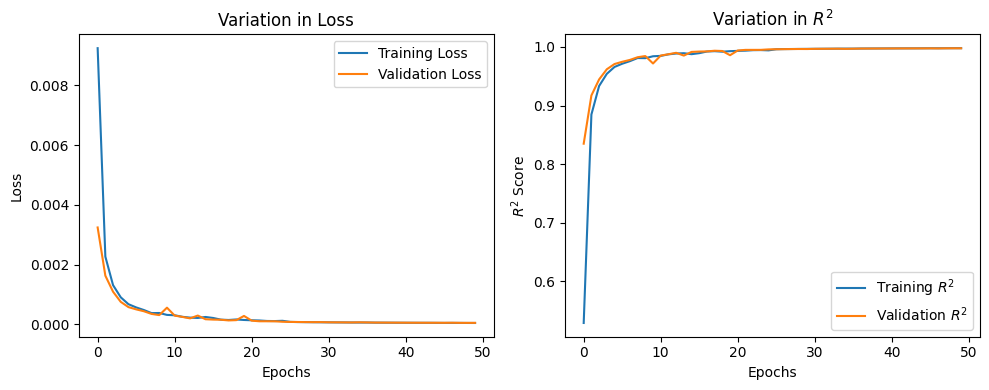

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(range(len(train_losses)), train_losses, label='Training Loss')
ax[0].plot(range(len(val_losses)), val_losses, label='Validation Loss')
ax[0].set_title('Variation in Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(len(train_r2_scores)), train_r2_scores, label='Training $R^2$')
ax[1].plot(range(len(val_r2_scores)), val_r2_scores, label='Validation $R^2$')
ax[1].set_title('Variation in $R^2$')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('$R^2$ Score')
ax[1].legend()

plt.tight_layout()
plt.show()

## Making Predictions on Test Data

In [10]:
test_input_data = np.load('/kaggle/input/cnn1024sliced/Preprocessed_Test_Halo.npz')['array']
test_output_data = np.load('/kaggle/input/cnn1024sliced/Preprocessed_Test_C2.npz')['array']

test_input_tensor = torch.tensor(test_input_data, dtype=torch.float32)
test_output_tensor = torch.tensor(test_output_data, dtype=torch.float32)

batch_size = 32
test_dataset = TensorDataset(test_input_tensor, test_output_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("Test Data Loaded")

Test Data Loaded


In [11]:
# Loading the saved model
model = UNet3D(in_channels=1, out_channels=1)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval() 

UNet3D(
  (enc1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (2): ReLU(inplace=True)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (2): ReLU(inplace=True)
    (3): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): MaxPool3d(kernel_size=2, stride

In [12]:

print("Making Predictions on Test Data")
predictions = []
true_outputs = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        true_outputs.append(targets.numpy())

predictions = np.concatenate(predictions, axis=0)
true_outputs = np.concatenate(true_outputs, axis=0)

np.savez_compressed('predictions.npz', array = predictions)
np.savez_compressed('true_outputs.npz', array = true_outputs)
print("Made Predictions on Test Data")

Making Predictions on Test Data
Made Predictions on Test Data


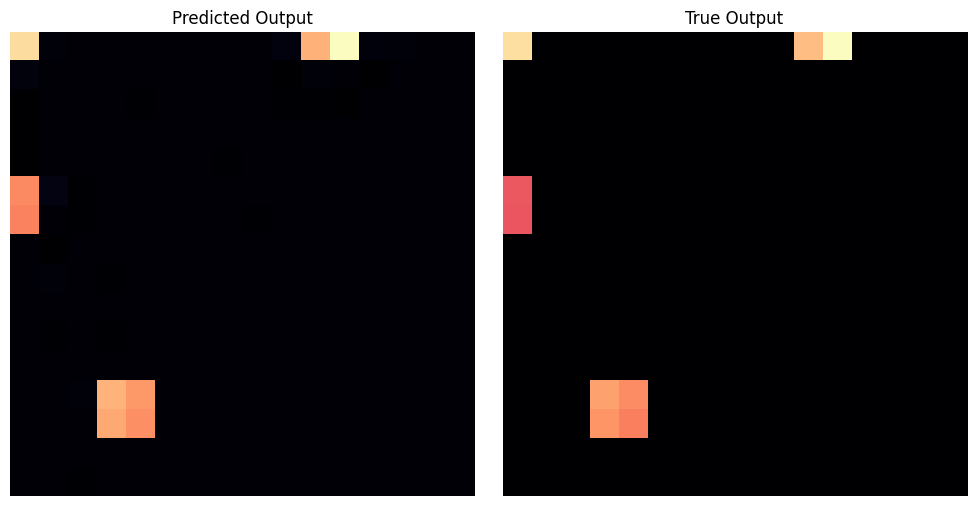

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(predictions[0][0][0], cmap='magma')
ax[0].set_title('Predicted Output')
ax[0].axis('off')

ax[1].imshow(true_outputs[0][0][0], cmap='magma')
ax[1].set_title('True Output')
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
predictions_flat = predictions.flatten()
true_outputs_flat = true_outputs.flatten()

mse = mean_squared_error(true_outputs_flat, predictions_flat)
print(f'Mean Squared Error (MSE): {mse}')

r2 = r2_score(true_outputs_flat, predictions_flat)
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 4.544419425656088e-05
R^2 Score: 0.9976847741461587


The End